# Installs & Imports

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
from typing import Optional, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import NotFittedError

import jax
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(jax.local_device_count())

# Data Loading

In [3]:
def load_time_series_data(url: str, index_col: str = None) -> pd.DataFrame:
    """
    Load time series data from a CSV file.

    Parameters:
    - url (str): The URL to the CSV file.
    - index_col (str, optional): Column to use as the row labels of the DataFrame.

    Returns:
    - pd.DataFrame: Loaded time series data.
    """
    try:
        df = pd.read_csv(url, index_col=index_col)
        print(f"Data loaded successfully from {url}")
        print(f"Number of records: {df.shape[0]}")
        return df
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        raise

In [4]:
# Load the data
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx_df = load_time_series_data(URL, index_col=0)
print("\nData preview:")
lynx_df.head(10)

Data loaded successfully from https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv
Number of records: 114

Data preview:


,time,value
rownames,,
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
6,1826,2821
7,1827,3928
8,1828,5943
9,1829,4950


In [5]:
def plot_time_series(
    df: pd.DataFrame,
    time_column: str,
    value_column: str,
    title: str = "Time Series Plot",
    figsize: tuple = (10, 5),
    line_style: str = "-",
    line_color: str = "blue",
    grid: bool = True
) -> None:
    """
    Plot a time series.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the time series data.
    - time_column (str): Name of the column representing time.
    - value_column (str): Name of the column representing values.
    - title (str, optional): Title of the plot.
    - figsize (tuple, optional): Size of the figure.
    - line_style (str, optional): Style of the line plot.
    - line_color (str, optional): Color of the line.
    - grid (bool, optional): Whether to display grid lines.

    Returns:
    - None
    """
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    plt.plot(
        df[time_column],
        df[value_column],
        linestyle=line_style,
        color=line_color,
        label=value_column
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Value", fontsize=14)

    if grid:
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

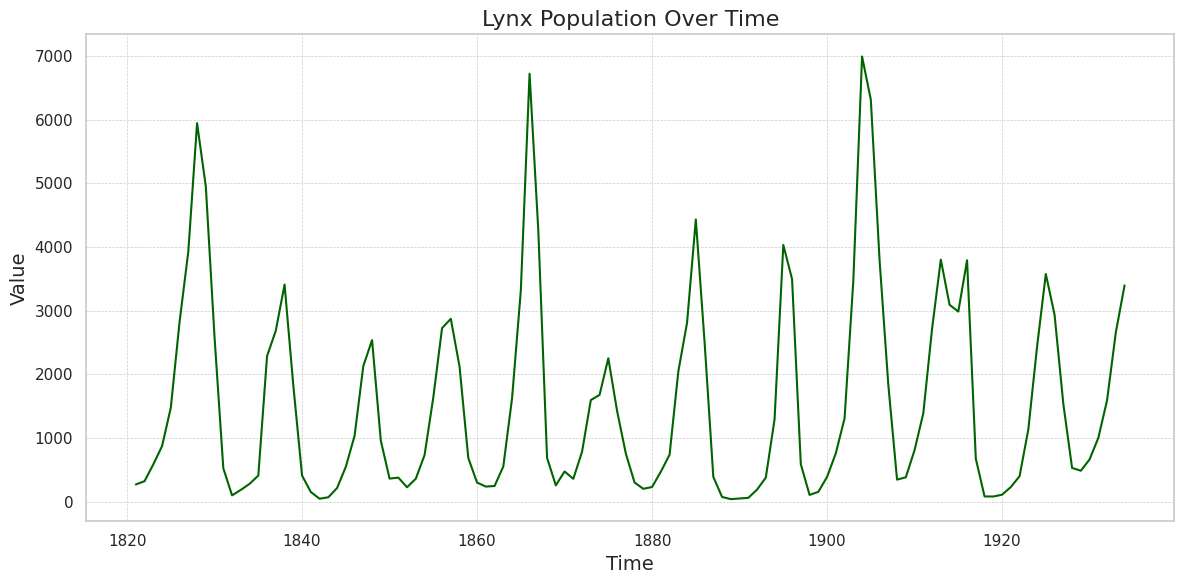

In [6]:
# Plot the data
plot_time_series(
    df=lynx_df,
    time_column="time",
    value_column="value",
    title="Lynx Population Over Time",
    figsize=(12, 6),
    line_color="darkgreen"
)

In [7]:
def plot_autocorrelation(
    df: pd.DataFrame,
    value_column: str,
    lags: int = 40,
    title: str = "Autocorrelation Plot"
) -> None:
    """
    Plot the autocorrelation of a time series.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - value_column (str): Name of the column to analyze.
    - lags (int, optional): Number of lags to display.
    - title (str, optional): Title of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))
    plot_acf(df[value_column], lags=lags, alpha=0.05)
    plt.title(title, fontsize=16)
    plt.xlabel("Lags", fontsize=14)
    plt.ylabel("Autocorrelation", fontsize=14)
    plt.tight_layout()
    plt.show()

<Figure size 1200x600 with 0 Axes>

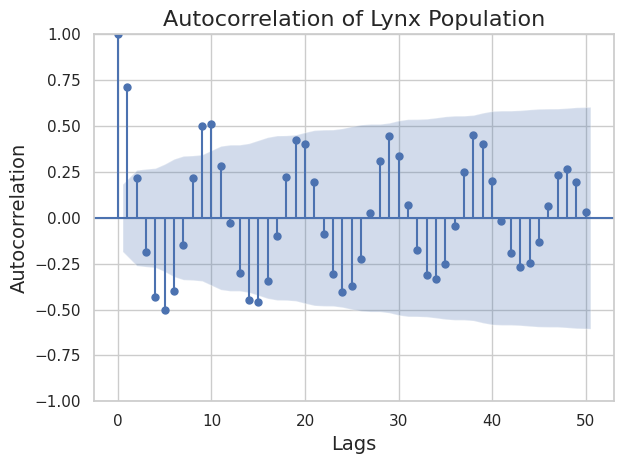

In [8]:
# Plot autocorrelation
plot_autocorrelation(lynx_df, "value", lags=50, title="Autocorrelation of Lynx Population")

# Data Splitting

In [9]:
def split_time_series_data(
    data: jnp.ndarray,
    train_size: float = 0.8,
    dtype: jnp.dtype = jnp.float32,
    random_seed: int = 42
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Split time series data into training and testing sets.

    Parameters:
    - data (jnp.ndarray): The complete time series data.
    - train_size (float, optional): Proportion of data to use for training (default is 0.8).
    - dtype (jnp.dtype, optional): Data type for the training set (default is jnp.float32).
    - random_seed (int, optional): Seed for reproducibility (default is 42).

    Returns:
    - Tuple[jnp.ndarray, jnp.ndarray]: Training and testing datasets.
    """
    if not 0 < train_size < 1:
        raise ValueError("train_size must be between 0 and 1.")

    split_index = int(len(data) * train_size)
    y_train = jnp.array(data[:split_index], dtype=dtype)
    y_test = jnp.array(data[split_index:], dtype=dtype)

    print(f"Data split into {split_index} training samples and {len(data) - split_index} testing samples.")
    return y_train, y_test

In [10]:
# Convert to JAX array
data = jnp.array(lynx_df["value"].values, dtype=jnp.float32)

# Split the data
y_train, y_test = split_time_series_data(data, train_size=0.8)

Data split into 91 training samples and 23 testing samples.


In [11]:
def analyze_autocorrelation(
    y_train: jnp.ndarray,
    max_lag: int = 40,
    plot: bool = True
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute and analyze autocorrelation of the training data.

    Parameters:
    - y_train (jnp.ndarray): Training time series data.
    - max_lag (int, optional): Maximum number of lags to compute (default is 40).
    - plot (bool, optional): Whether to plot the autocorrelation (default is True).

    Returns:
    - Tuple[jnp.ndarray, jnp.ndarray]: Sorted lags and corresponding autocorrelation values.
    """
    # Compute autocorrelation for all lags up to max_lag
    autocorr_full = autocorrelation(y_train)[:max_lag + 1]  # +1 to include max_lag

    # Exclude lag 0 for sorting and plotting
    autocorr_excl_zero = autocorr_full[1:]
    lags = jnp.arange(1, len(autocorr_full))

    # Sort lags by autocorrelation in descending order
    sorted_indices = jnp.argsort(autocorr_excl_zero)[::-1]
    sorted_lags = lags[sorted_indices]

    print("Lag values sorted by autocorrelation (excluding lag 0):\n")
    print(sorted_lags)
    print("\n")

    if plot:
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=lags,
            y=autocorr_excl_zero,
            palette="viridis",
            hue=autocorr_excl_zero,
            dodge=False,
            legend=False
        )
        plt.title("Autocorrelation of Training Data", fontsize=16)
        plt.xlabel("Lag", fontsize=14)
        plt.ylabel("Autocorrelation", fontsize=14)
        plt.xticks(fontsize=8)
        plt.tight_layout()
        plt.grid()
        plt.show()

    return sorted_lags, autocorr_full

Lag values sorted by autocorrelation (excluding lag 0):

[ 1 38 10  9 19 39 29 37 20 28 18 47  2 48 30 11  8 40 49 46 21 27 36 31
 17 50 45 41 12 22  7 26 35  3 32 44 42 16 43 34 23 33 25 13 24 15  6 14
  4  5]




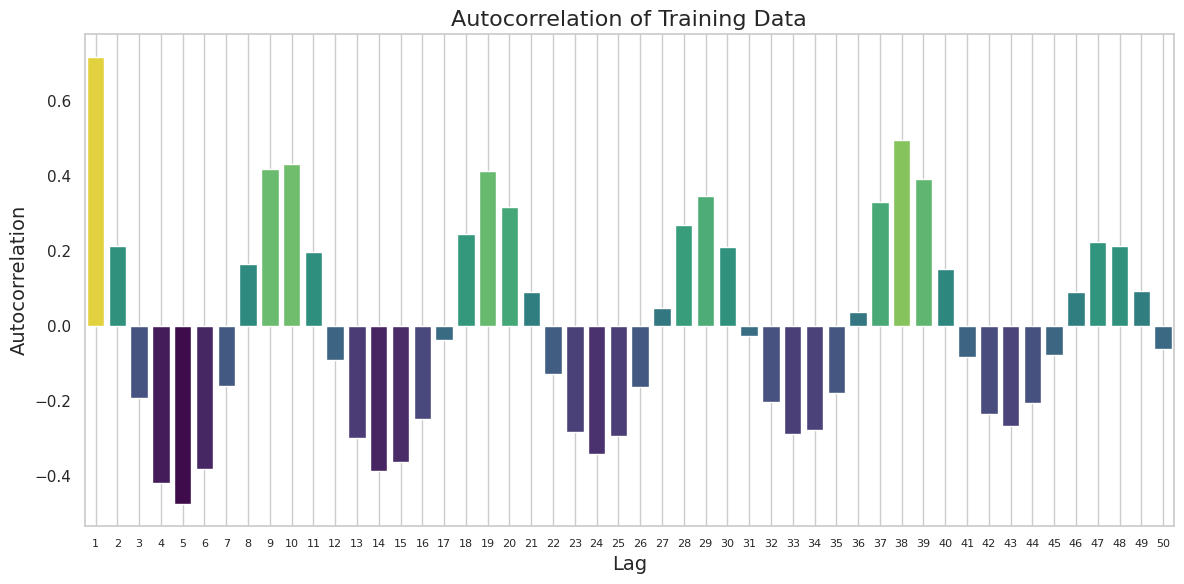

In [12]:
# View sorted lags and autocorrelation plot
sorted_lags, autocorr_values = analyze_autocorrelation(
    y_train,
    max_lag=50,
    plot=True
)

In [13]:
def plot_sorted_autocorrelation(
    autocorr_values: jnp.ndarray,
    sorted_lags: jnp.ndarray,
    top_n: int = 10
) -> None:
    """
    Plot the top N lags with the highest autocorrelation values in descending order.

    Parameters:
    - autocorr_values (jnp.ndarray): Array of autocorrelation values.
    - sorted_lags (jnp.ndarray): Array of sorted lag indices.
    - top_n (int, optional): Number of top lags to plot (default is 10).

    Returns:
    - None
    """
    # Exclude lag 0 if it's included
    sorted_lags = sorted_lags[sorted_lags > 0]

    # Adjust top_n if it exceeds available lags
    top_n = min(top_n, len(sorted_lags))
    if top_n < 1:
        raise ValueError("top_n must be at least 1.")

    # Select the top N lags
    top_lags = sorted_lags[:top_n]
    top_values = autocorr_values[top_lags]

    # Create a DataFrame
    df_top = pd.DataFrame({
        'Lag': top_lags,
        'Autocorrelation': top_values
    })

    # Sort the DataFrame by Autocorrelation in descending order
    df_top_sorted = df_top.sort_values(by='Autocorrelation', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Lag',
        y='Autocorrelation',
        data=df_top_sorted,
        order=df_top_sorted['Lag'],
        palette="viridis",
        hue='Autocorrelation',
        dodge=False,
        legend=False
    )

    plt.title(f"Top {top_n} Lags by Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=14)
    plt.ylabel("Autocorrelation", fontsize=14)
    plt.xticks(fontsize=8)
    plt.tight_layout()
    plt.show()

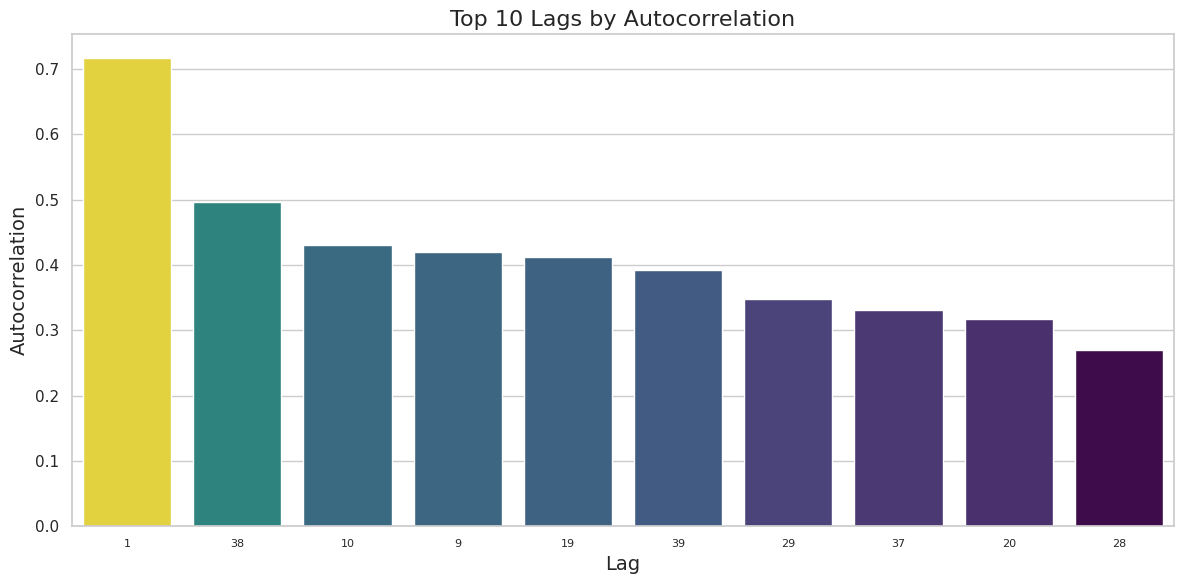

In [14]:
# Plot the top 10 lags with highest autocorrelation in descending order
plot_sorted_autocorrelation(
    autocorr_values=autocorr_values,
    sorted_lags=sorted_lags,
    top_n=10
)

# Model Fitting

In [15]:
class SGTModel(BaseEstimator, RegressorMixin):
    """
    Seasonal Global Trend (SGT) Model compatible with scikit-learn API.

    This model performs Bayesian time series forecasting using a Seasonal Global Trend approach.
    It leverages NumPyro for probabilistic modeling and JAX for high-performance computations.

    Parameters
    ----------
    seasonality : int
        The number of periods in a season.
    num_warmup : int, default=5000
        Number of warmup (burn-in) steps for MCMC sampling.
    num_samples : int, default=5000
        Number of MCMC samples to draw after warmup.
    num_chains : int, default=4
        Number of MCMC chains to run in parallel.
    random_seed : int, default=0
        Seed for random number generation to ensure reproducibility.
    """

    def __init__(
        self,
        seasonality: int,
        num_warmup: int = 5000,
        num_samples: int = 5000,
        num_chains: int = 4,
        random_seed: int = 0,
    ):
        """
        Initialize the SGTModel with hyperparameters.

        Parameters
        ----------
        seasonality : int
            The number of periods in a season.
        num_warmup : int, default=5000
            Number of warmup steps for MCMC.
        num_samples : int, default=5000
            Number of samples to draw from the posterior.
        num_chains : int, default=4
            Number of parallel MCMC chains.
        random_seed : int, default=0
            Seed for random number generation.
        """
        self.seasonality = seasonality
        self.num_warmup = num_warmup
        self.num_samples = num_samples
        self.num_chains = num_chains
        self.random_seed = random_seed
        self._mcmc = None                # To store the MCMC object after fitting
        self._posterior_samples = None   # To store posterior samples
        self._is_fitted = False          # Flag to indicate if the model is fitted
        self.y_train = None              # To store the training data
        self.y_forecast = None           # To store marginal forecast

    def _define_sgt_model(self, y: jnp.ndarray, seasonality: int, future: int = 0):
        """
        Internal method defining the SGT model using NumPyro's probabilistic programming.

        Parameters
        ----------
        y : jnp.ndarray
            Observed time series data.
        seasonality : int
            Number of periods in a season.
        future : int, default=0
            Number of future steps to forecast.

        Returns
        -------
        None
        """
        # Heuristic for the standard deviation of the Cauchy prior based on data
        cauchy_sd = jnp.max(y) / 150

        # Define priors for model parameters
        nu = numpyro.sample("nu", dist.Uniform(2, 20))
        powx = numpyro.sample("powx", dist.Uniform(0, 1))
        sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
        offset_sigma = numpyro.sample(
            "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
        )

        coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
        pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))

        # Scale pow_trend to range [-0.5, 1]
        pow_trend = 1.5 * pow_trend_beta - 0.5
        pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

        level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
        s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
        init_s = numpyro.sample(
            "init_s", dist.Cauchy(0, y[:seasonality] * 0.3)
        )

        def state_transition(carry: Tuple[jnp.ndarray, jnp.ndarray, float], t: int):
            """
            State transition function for the SGT model.

            Parameters
            ----------
            carry : Tuple[jnp.ndarray, jnp.ndarray, float]
                Current state containing (level, seasonal components, moving sum).
            t : int
                Current time step.

            Returns
            -------
            Tuple[Tuple[jnp.ndarray, jnp.ndarray, float], float]
                Updated state and the sampled observation at time t.
            """
            level, seasonal, moving_sum = carry
            season_effect = seasonal[0] * level**pow_season
            expected_value = level + coef_trend * level**pow_trend + season_effect
            expected_value = jnp.clip(expected_value, 0)

            # Use expected value for forecasting beyond observed data
            observed_or_expected = jnp.where(t >= N, expected_value, y[t])

            # Update moving sum for level computation
            moving_sum += y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
            level_potential = jnp.where(
                t >= seasonality, moving_sum / seasonality, observed_or_expected - season_effect
            )
            updated_level = level_sm * level_potential + (1 - level_sm) * level
            updated_level = jnp.clip(updated_level, 0)

            # Update seasonal components
            new_seasonal = (s_sm * (observed_or_expected - updated_level) / season_effect + (1 - s_sm)) * seasonal[0]
            new_seasonal = jnp.where(t >= N, seasonal[0], new_seasonal)
            updated_seasonal = jnp.concatenate([seasonal[1:], new_seasonal[None]], axis=0)

            # Define the observation noise
            omega = sigma * expected_value**powx + offset_sigma

            # Sample the observation at time t
            sampled_y = numpyro.sample("y", dist.StudentT(nu, expected_value, omega))

            return (updated_level, updated_seasonal, moving_sum), sampled_y

        N = y.shape[0]
        initial_level = y[0]
        initial_seasonal = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
        initial_moving_sum = initial_level

        # Condition the model on observed data
        with numpyro.handlers.condition(data={"y": y[1:]}):
            _, sampled_y = scan(
                state_transition,
                (initial_level, initial_seasonal, initial_moving_sum),
                jnp.arange(1, N + future)
            )

        # If forecasting, add deterministic predictions
        if future > 0:
            numpyro.deterministic("y_forecast", sampled_y[-future:])

    def fit(self, X: Optional[jnp.ndarray] = None, y: Optional[jnp.ndarray] = None) -> 'SGTModel':
        """
        Fit the SGT model to the provided time series data.

        Parameters
        ----------
        X : jnp.ndarray or None, default=None
            Feature matrix. Not used in this model.
        y : jnp.ndarray or None, default=None
            Target time series data.

        Returns
        -------
        self : SGTModel
            The fitted model instance.
        """
        if y is None:
            raise ValueError("Target variable y must be provided for fitting.")

        # Ensure y is a JAX array
        if not isinstance(y, jax.Array):
            y_jax = jnp.array(y, dtype=jnp.float32)
        else:
            y_jax = y

        # Store y_train for use in prediction
        self.y_train = y_jax

        # Define the NUTS sampler with the SGT model
        nuts_kernel = NUTS(self._define_sgt_model)

        # Initialize the MCMC sampler
        self._mcmc = MCMC(
            nuts_kernel,
            num_warmup=self.num_warmup,
            num_samples=self.num_samples,
            num_chains=self.num_chains,
            progress_bar=True
        )

        # Generate a random key for reproducibility
        rng_key = random.PRNGKey(self.random_seed)

        # Run MCMC sampling
        self._mcmc.run(rng_key, y=y_jax, seasonality=self.seasonality)

        # Print a summary of the sampling
        self._mcmc.print_summary()

        # Retrieve posterior samples
        self._posterior_samples = self._mcmc.get_samples()

        # Mark the model as fitted
        self._is_fitted = True

        return self

    def predict(self, X: Optional[jnp.ndarray] = None, future_steps: int = 0) -> jnp.ndarray:
        """
        Predict future values using the fitted SGT model.

        Parameters
        ----------
        X : jnp.ndarray or None, default=None
            Feature matrix. Not used in this model.
        future_steps : int, default=0
            Number of future time steps to predict.

        Returns
        -------
        predictions : jnp.ndarray
            Predicted future values.
        """
        if not self._is_fitted:
            raise NotFittedError("SGTModel instance is not fitted yet. Call 'fit' first.")

        if future_steps <= 0:
            raise ValueError("future_steps must be a positive integer.")

        # Initialize the predictive object with the fitted posterior samples
        predictive = Predictive(
            self._define_sgt_model,
            posterior_samples=self._posterior_samples,
            return_sites=["y_forecast"],
        )

        # Generate a new random key for prediction
        rng_key = random.PRNGKey(self.random_seed + 1)  # Increment seed for diversity

        # Perform posterior predictive sampling
        forecast_samples = predictive(
            rng_key,
            y=self.y_train,
            seasonality=self.seasonality,
            future=future_steps
        )

        # Extract the forecasted values
        if "y_forecast" in forecast_samples:
            y_forecast = forecast_samples["y_forecast"]
            self.y_forecast = y_forecast

            # Compute the mean prediction across all posterior samples and chains
            predictions = jnp.mean(y_forecast, axis=0)
            return predictions
        else:
            raise RuntimeError("Prediction failed. 'y_forecast' not found in samples.")

    def set_params(self, **params: Any) -> 'SGTModel':
        """
        Set the parameters of the model.

        Parameters
        ----------
        **params : dict
            Parameters to set.

        Returns
        -------
        self : SGTModel
            The model instance with updated parameters.
        """
        super().set_params(**params)
        return self

    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        """
        Get the parameters of the model.

        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.

        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        return super().get_params(deep=deep)

    def score(self, X: Optional[jnp.ndarray] = None, y_true: Optional[jnp.ndarray] = None) -> float:
        """
        Compute the negative mean squared error of the model on the given data.

        Parameters
        ----------
        X : jnp.ndarray or None, default=None
            Feature matrix. Not used in this model.
        y_true : jnp.ndarray or None, default=None
            True values for comparison.

        Returns
        -------
        score : float
            Negative mean squared error (higher is better).
        """
        if y_true is None:
            raise ValueError("True values y_true must be provided for scoring.")

        # Number of future steps to predict should match the length of y_true
        future_steps = y_true.shape[0]

        # Generate predictions
        y_pred = self.predict(future_steps=future_steps)

        # Calculate mean squared error
        mse = mean_squared_error(y_true, y_pred)

        # Return negative MSE
        return -mse

In [16]:
# Initialize the SGTModel
seasonality_periods = 38
sgt_model = SGTModel(
    seasonality=seasonality_periods,
    num_warmup=5000,
    num_samples=5000,
    num_chains=4,
    random_seed=42
)

In [17]:
# Fit the model to the training data
warnings.filterwarnings("ignore", category=UserWarning)
print("Fitting the SGTModel to training data...")
sgt_model.fit(y=y_train)

Fitting the SGTModel to training data...


sample: 100%|██████████| 10000/10000 [47:35<00:00,  3.50it/s, 63 steps of size 5.89e-02. acc. prob=0.83]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     32.24    110.68     14.37    -99.30    162.07   1534.61      1.00
       init_s[0]     79.44    105.47     58.06    -66.36    225.54   2917.03      1.00
       init_s[1]    -18.61     68.64    -22.80   -127.91     85.50   5977.54      1.00
       init_s[2]     29.38     90.00     17.70   -112.44    162.72   6980.63      1.00
       init_s[3]    114.50    118.67     97.68    -68.79    287.67   5494.67      1.00
       init_s[4]    349.86    190.84    320.45     55.52    634.61   4821.83      1.00
       init_s[5]    933.71    360.99    879.34    376.66   1461.97   2884.42      1.00
       init_s[6]   1822.85    563.84   1744.55    956.28   2697.63   2201.76      1.00
       init_s[7]   3560.79    992.65   3440.50   1995.85   5130.55   1801.80      1.00
       init_s[8]   2761.78    806.16   2657.48   1509.65   4033.87   1890.42      1.00
       init_s[9]   1321.85    480.73   124

SGTModel(random_seed=42, seasonality=38)

# Model Evaluation

In [18]:
# Define the number of future steps to predict (length of y_test)
future_steps = y_test.shape[0]

In [19]:
# Generate predictions for the future steps
print(f"Predicting the next {future_steps} steps...")
y_pred = sgt_model.predict(future_steps=future_steps)

Predicting the next 23 steps...


In [20]:
# Display predictions and actual values
print("Predictions:", y_pred)
print("Actual:", y_test)

Predictions: [2025.2053  2524.2664  2682.7754  1437.6442   465.9881   364.57043
  393.22897  432.02     529.81866 1318.1035  1988.2234  3407.596
 2575.653    809.11395  436.8378   442.18204  387.8277   442.2728
  656.08466 1290.464   2238.9417  3554.1384  2882.0728 ]
Actual: [2713. 3800. 3091. 2985. 3790.  674.   81.   80.  108.  229.  399. 1132.
 2432. 3574. 2935. 1537.  529.  485.  662. 1000. 1590. 2657. 3396.]


In [21]:
# Evaluate the model using the score method (negative MSE)
model_score = sgt_model.score(y_true=y_test)
print(f"Model Score (Negative MSE): {model_score}")

Model Score (Negative MSE): -1817247.625


In [22]:
def compute_forecast_metrics(y_train: jnp.ndarray, y_test: jnp.ndarray, y_pred: jnp.ndarray) -> pd.DataFrame:
    """
    Compute forecast accuracy metrics between true values and predictions, including MASE based on training data.

    Parameters
    ----------
    y_train : jnp.ndarray
        Training data of the target variable, used to compute the MAE of a naive forecast.
    y_test : jnp.ndarray
        True values of the target variable.
    y_pred : jnp.ndarray
        Predicted values of the target variable.

    Returns
    -------
    metrics_df : pd.DataFrame
        A DataFrame containing the following metrics in order:
            - RMSE: Root Mean Squared Error
            - MAE: Mean Absolute Error
            - MAPE: Mean Absolute Percentage Error
            - sMAPE: Symmetric Mean Absolute Percentage Error
            - MASE: Mean Absolute Scaled Error
    """
    # Ensure y_train, y_test, and y_pred are JAX arrays
    for var_name, var in zip(['y_train', 'y_test', 'y_pred'], [y_train, y_test, y_pred]):
        if not isinstance(var, jax.Array):
            raise TypeError(f"{var_name} must be a JAX array.")

    # Validate that y_test and y_pred have the same shape
    if y_test.shape != y_pred.shape:
        raise ValueError("Shapes of y_test and y_pred must be the same.")

    # Compute root mean squared error (RMSE)
    rmse = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))

    # Compute mean absolute error (MAE)
    mae = jnp.mean(jnp.abs(y_pred - y_test))

    # Compute mean absolute percentage error (MAPE)
    # To avoid division by zero, add a small epsilon where y_test is zero
    epsilon = 1e-10
    mape = jnp.mean(jnp.abs((y_pred - y_test) / (y_test + epsilon))) * 100

    # Compute symmetric mean absolute percentage error (sMAPE)
    smape = jnp.mean(
        2 * jnp.abs(y_pred - y_test) / (jnp.abs(y_pred) + jnp.abs(y_test) + epsilon)
    ) * 100

    # Compute mean absolute scaled error (MASE)
    # Calculate the in-sample MAE of the naive forecast based on y_train
    if y_train.shape[0] < 2:
        raise ValueError("y_train must contain at least two observations to compute MASE.")
    mae_naive = jnp.mean(jnp.abs(y_train[1:] - y_train[:-1]))
    mase = mae / (mae_naive + epsilon)  # Add epsilon to avoid division by zero

    # Compile the metrics into a dictionary
    metrics = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "sMAPE": smape,
        "MASE": mase
    }

    # Convert the metrics dictionary to a pandas DataFrame
    metrics_df = pd.DataFrame(
        [metrics],
        columns=["RMSE", "MAE", "MAPE", "sMAPE", "MASE"]
    )

    return metrics_df

In [23]:
# Display metrics DataFrame
metrics_df = compute_forecast_metrics(y_train=y_train, y_test=y_test, y_pred=y_pred)
print("Forecast Accuracy Metrics:")
display(metrics_df)

Forecast Accuracy Metrics:


,RMSE,MAE,MAPE,sMAPE,MASE
0,1348.0532,984.1021,127.97084,73.08971,1.1554863


In [24]:
def plot_predictions_with_hpdi(
    y_train: jnp.ndarray,
    y_test: jnp.ndarray,
    y_pred: jnp.ndarray,
    forecast_marginal: jnp.ndarray,
    time_train: Optional[jnp.ndarray] = None,
    time_test: Optional[jnp.ndarray] = None,
    title: str = "SGT Model Predictions with HPDI",
    hpdi_prob: float = 0.90
) -> None:
    """
    Plot the historical data, predictions, and High Posterior Density Intervals (HPDI) for the model.

    Parameters
    ----------
    y_train : jnp.ndarray
        Historical training data.
    y_test : jnp.ndarray
        True future values.
    y_pred : jnp.ndarray
        Predicted future values (mean).
    forecast_marginal : jnp.ndarray
        Forecast samples object from the predictive posterior (shape: [num_samples, future_steps]).
    time_train : jnp.ndarray or None, default=None
        Time steps for the historical data. If None, integer indices are used.
    time_test : jnp.ndarray or None, default=None
        Time steps for the forecasted data. If None, integer indices are used starting from len(y_train).
    title : str, default="SGT Model Predictions with HPDI"
        Title of the plot.
    hpdi_prob : float, default=0.90
        Probability for the HPDI intervals (e.g., 0.90 for 90% HPDI).
    """
    # Validate input shapes
    if y_test.shape != y_pred.shape:
        raise ValueError("Shapes of y_test and y_pred must be the same.")
    if forecast_marginal.shape[1] != y_pred.shape[0]:
        raise ValueError("forecast_marginal must match the length of y_pred.")

    # If time indices are not provided, create integer indices
    if time_train is None:
        time_train = jnp.arange(len(y_train))
    if time_test is None:
        time_test = jnp.arange(len(y_train), len(y_train) + len(y_test))

    # Compute HPDI for forecast_marginal
    hpdi_low, hpdi_high = hpdi(forecast_marginal, prob=hpdi_prob)

    # Convert to numpy for plotting
    y_train_np = np.array(y_train)
    y_test_np = np.array(y_test)
    y_pred_np = np.array(y_pred)
    hpdi_low_np = np.array(hpdi_low)
    hpdi_high_np = np.array(hpdi_high)
    time_train_np = np.array(time_train)
    time_test_np = np.array(time_test)

    # Create the plot
    plt.figure(figsize=(14, 7))
    sns.set(style="whitegrid")

    # Plot training set data
    plt.plot(time_train_np, y_train_np, label="Training Data", color="blue", marker='o')

    # Plot test set data
    plt.plot(time_test_np, y_test_np, label="Test Data", color="green", marker='o')

    # Plot predicted values
    plt.plot(time_test_np, y_pred_np, label="Forecast Data", color="red", linestyle="--", marker='x')

    # Plot HPDI intervals
    plt.fill_between(time_test_np, hpdi_low_np, hpdi_high_np, color='gray', alpha=0.3, label=f"{int(hpdi_prob*100)}% HPDI")

    # Add titles and labels
    plt.title(title, fontsize=18)
    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel("Value", fontsize=14)

    # Add legend
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
# Convert to JAX array
time_data = jnp.array(lynx_df["time"].values, dtype=jnp.float32)

# Split the data
time_train, time_test = split_time_series_data(time_data, train_size=0.8)

Data split into 91 training samples and 23 testing samples.


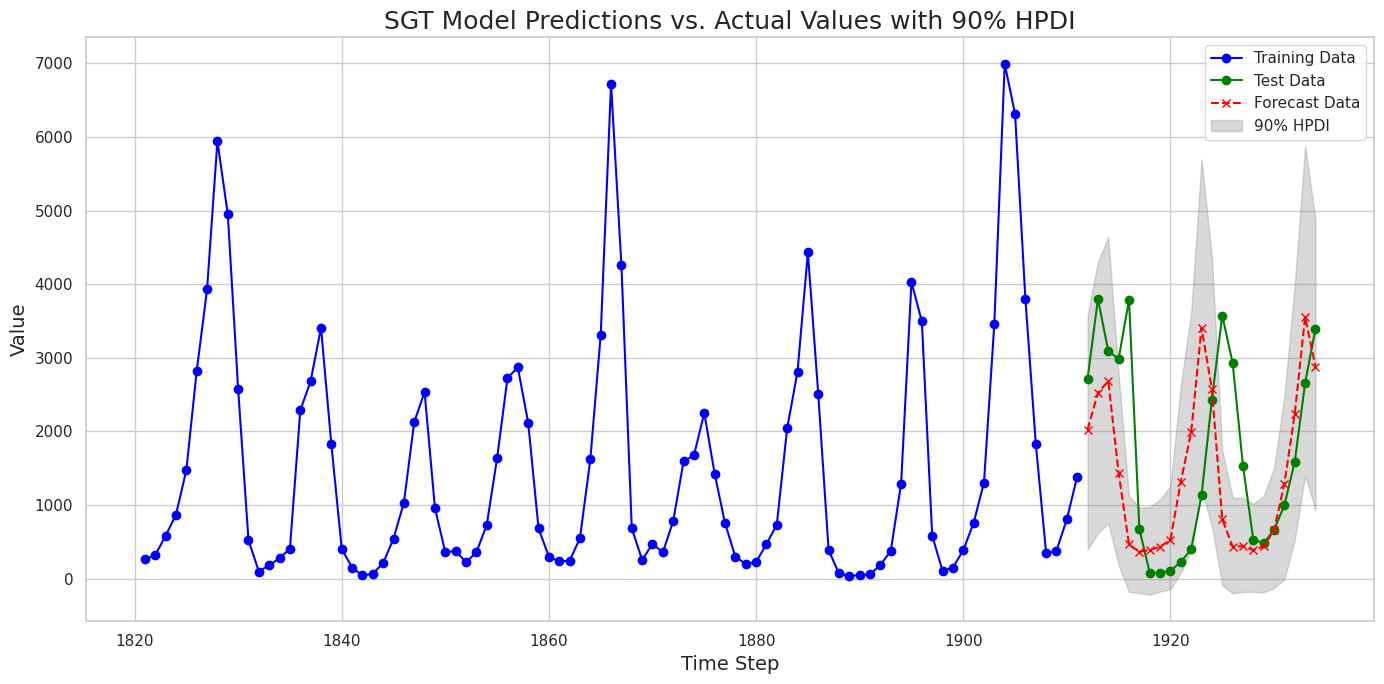

In [26]:
# Plot the predictions with HPDI
forecast_marginal = sgt_model.y_forecast
plot_predictions_with_hpdi(
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred,
    forecast_marginal=forecast_marginal,
    time_train=time_train,
    time_test=time_test,
    title="SGT Model Predictions vs. Actual Values with 90% HPDI",
    hpdi_prob=0.90
)